In [1]:
%matplotlib inline

import QuantLib as ql
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
from flags import *
for k,v in FLAGS.__dict__.items():
    print(k,'--->',v)

SPOT ---> 53
DRIFT ---> 0.01
SIGMA ---> 0.2
STRIKE ---> 53.0
SMALL_SAMPLE ---> 500
SAMPLES ---> 20000
RF_RATE ---> 0.05
TODAY ---> November 25th, 2019
MATURITY ---> January 8th, 2020


### Followinf DeepHeadging-Bühler-2018

Proof of concept: If stocks are GBM with arbitrary drift then a continous delta hedging would give the BS price of the option. For discrete time this is not true and the BS price of a daily Delta-headged option is the maximum of the replicating portfolios.

Replicating portfolio:
$$\Pi_t=\Delta_t S_t + z_t B_t$$
where $\Delta_t$ and $z_t$ are number of shares and bond resp. heald in $[t,t+\Delta t)$. The porfolio is self-financing meaning that $\Pi_t = \Delta_{t-1} S_t+z_{t-1}B_t$.

Then the PnL of selling the option at price $p_0$ and then using $\Pi_t$ to replicate the position is 
$$PnL_T=p_0-C_T+\Pi_T$$


$B_t$ is the price of a bound with deterministic rate $r$:

$B_t=B_{t-1}e^{-r\Delta t}$ where $\Delta t$ is in Actual365Fixed yearfractions.

In [3]:
def discount_factor(dates,
                    tradeDate=FLAGS.TODAY,
                    rf_rate=FLAGS.RF_RATE):
    
    yearfraction = [ql.Actual365Fixed().yearFraction(dates[0],d) for d in dates]
    
    rate = ql.SimpleQuote(rf_rate)
    disc_curve = ql.FlatForward(tradeDate, ql.QuoteHandle(rate), ql.Actual365Fixed())
    disc_curve.enableExtrapolation()
    discount = np.vectorize(ql.YieldTermStructureHandle(disc_curve).discount)
    return discount(yearfraction)

Generate GBM paths (daily) with quantlib.

$$S_{t+\Delta t}=S_te^{(\mu-\sigma^2/2)\Delta t + \sigma\sqrt{\Delta t}N_{0,1}}$$

In [4]:
import path_generator
import model_pricing

### Sample paths:

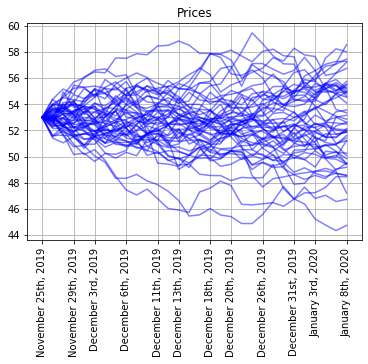

In [5]:
gbm_paths,values,time_grid = path_generator.BS_Generator(n_paths=1000)

idx = np.round(np.linspace(0, len(time_grid) - 1, 12)).astype(int)
plt.figure()
plt.plot(np.transpose(gbm_paths[:50,:]),color='blue', alpha=0.5)
plt.grid(1)
plt.xticks(idx, np.array(time_grid)[idx], rotation=90)
plt.title('Prices')
plt.show()

## Pricing and Deltas according to the BS equations


$$C(S_t,t;K,T) = S_t N(d_1) - Ke^{-r\Delta t}N(d_2)$$

$$\Delta(S_t,t;K,T)=N(d_1)$$

wehere $d_1=\frac{\log(S_t/K)+(r-\sigma^2/2)\Delta t}{\sigma\sqrt{\Delta t}}$ and $d_2 = d_1-\sigma\sqrt{\Delta t}$


For each path generate computes the initial BS price $C_0$ for reference. Then construct the self financing portfolio $\Pi_t$ dynamically, and computes the price $p_i=C_T-\Pi_T$. Computes also the PnL path: $PnL_t=C_0+\Pi_t-C_t$.

In a incomplete market an agent would like hedg in order to minimize a meaure of the risk of its portfolio:
$$\inf\limits_H \rho(C_T − (C_0 + \Pi_T))$$

Here we do the converse. We claim a complete market adn a given headge strategy $H$. In complete markets $\inf\limits_H \rho(C_T − (C_0 + \Pi_T))=0$ and $H,\Pi_T,C_T$ are given and so we are left to estimate $C_0$, as $\rho(C_T-\Pi_T)$

In [6]:
P = []
PNL = []

dsc = discount_factor(time_grid)

for path in tqdm(gbm_paths[:1000]):
    
    stock_returns = np.diff(path)

    mtm_option = model_pricing.price_BS_option(val_date = time_grid, spot_price = path)
    option_final_price = mtm_option[-1] #price_option(val_date = time_grid[-1], spot_price = path[-1])
    deltas = model_pricing.delta_BS_option(val_date = time_grid, spot_price = path)
    deltas[-1] = 0
    
    portfolio = np.zeros(np.shape(dsc))
    z = np.zeros(np.shape(dsc))
    
    z[0] = -deltas[0]*path[0]/dsc[0]
    
    for i in range(1,len(deltas)):
        
        z[i] = ((dsc[i]*z[i-1]+deltas[i-1]*path[i])-deltas[i]*path[i])/dsc[i]
        portfolio[i] = deltas[i]*path[i] + z[i]*dsc[i]
    
    price = option_final_price-portfolio[-1]
    P.append(price)
    pnl = mtm_option[0]+portfolio-mtm_option
    PNL.append(pnl)
    
PNL = np.array(PNL)    
P = np.array(P)

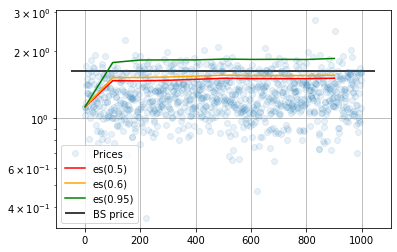

In [7]:
var = lambda P,alpha: -np.percentile(-P,alpha*100,interpolation='higher')
es = lambda P,alpha: np.mean([var(P,l) for l in np.linspace(0,1-(alpha),100)])

alpha1 = 0.5
alpha2 = 0.6
alpha3 = 0.95

plt.figure()
plt.plot(P,'o',alpha=0.1)
plt.plot(range(1,len(P),100),[es(P[:i],alpha1) for i in range(1,len(P),100)],color = 'r')
plt.plot(range(1,len(P),100),[es(P[:i],alpha2) for i in range(1,len(P),100)],color = 'orange')
plt.plot(range(1,len(P),100),[es(P[:i],alpha3) for i in range(1,len(P),100)],color = 'green')
plt.hlines(mtm_option[0],plt.xlim()[0],plt.xlim()[1])
plt.grid(1)
plt.yscale('log')
plt.legend(['Prices','es('+str(alpha1)+')','es('+str(alpha2)+')','es('+str(alpha3)+')','BS price'])
plt.show()

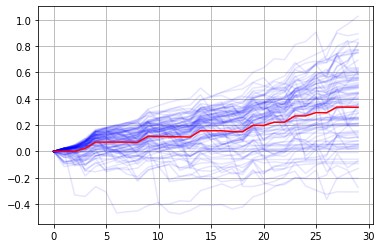

In [11]:
plt.figure()
plt.plot(PNL[1:100].T,alpha=0.1,color='b')
plt.plot(np.mean(PNL,axis=0),color='r')
plt.grid(1)
plt.show()

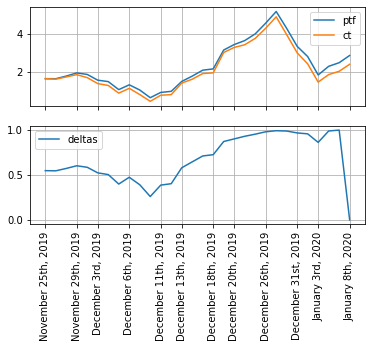

In [31]:
plt.figure()
ax1 = plt.subplot(211)
#plt.plot(path)
plt.plot(portfolio+mtm_option[0])
plt.plot(mtm_option)
plt.grid()
plt.legend(['ptf','ct'])
plt.setp(ax1.get_xticklabels(), visible=False)
ax2 = plt.subplot(212, sharex=ax1)
plt.plot(deltas)
plt.grid(1)
plt.xticks(idx, np.array(time_grid)[idx], rotation=90)
plt.legend(['deltas'])
plt.show()